# Pysindy with DEC data

In [1]:
import dctkit as dt
from dctkit import config
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from dctkit.mesh import util
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.dec import cochain as C
from dctkit.dec.vector import flat_PDP as flat
from matplotlib import cm
import pysindy as ps
from alpine.data.util import load_dataset
from alpine.data.burgers.burgers_dataset import data_path
from dctkit.physics import burgers as b
import math

In [2]:
config()

In [3]:
# SPACE PARAMS
# spatial resolution
dx = 5/2**8
L = 5 + dx
dx_norm = dx/L
L_norm = 1
#  Number of spatial grid points
num_x_points = int(math.ceil(L / dx))
num_x_points_norm = num_x_points

# vector containing spatial points
x = np.linspace(0, L, num_x_points)
x_circ = (x[:-1] + x[1:])/2

# initial velocity
u_0 = 2 * np.exp(-2 * (x_circ - 0.5 * L)**2)
umax = np.max(u_0)

# TIME PARAMS
T = 2
T_norm = T*umax/L
# temporal resolution
dt = 2/2**10
dt_norm = dt*umax/L
# number of temporal grid points
num_t_points_norm = int(math.ceil(T_norm / dt_norm))


t = np.linspace(0, T_norm, num_t_points_norm)

# Viscosity
epsilon = 0.005*(L*umax)
epsilon_norm = epsilon/(L*umax)

nodes_BC = {'left': np.zeros(num_t_points_norm),
                'right': np.zeros(num_t_points_norm)}

In [4]:
# generate mesh
mesh, _ = util.generate_line_mesh(num_x_points_norm, L_norm)
S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_PDP_weights()
# get circ
circ = S.circ[1][:,0]

In [5]:
# load data
time_train, time_val, time_test, u_train_T, u_val_T, u_test_T = load_dataset(
    data_path, "npy")

In [6]:
# construct full u (only for plotting and u_dot)
prb = b.Burgers(L_norm, T_norm, dx_norm, dt_norm, u_0/umax, nodes_BC, epsilon_norm)
prb.run("parabolic")

In [7]:
u = prb.u
u_dot_true = ps.FiniteDifference(axis=1)._differentiate(u, t=dt_norm)

In [8]:
# define skip_dx and skip_dt
skip_dx = 2**1
skip_dt = 2**0

# define sub-sampled mesh and time interval
t_sample = t[::skip_dt]
circ_sample = circ[::skip_dx]

u_sample = u[::skip_dx, ::skip_dt]
u_dot_sample = u_dot_true[::skip_dx, ::skip_dt]

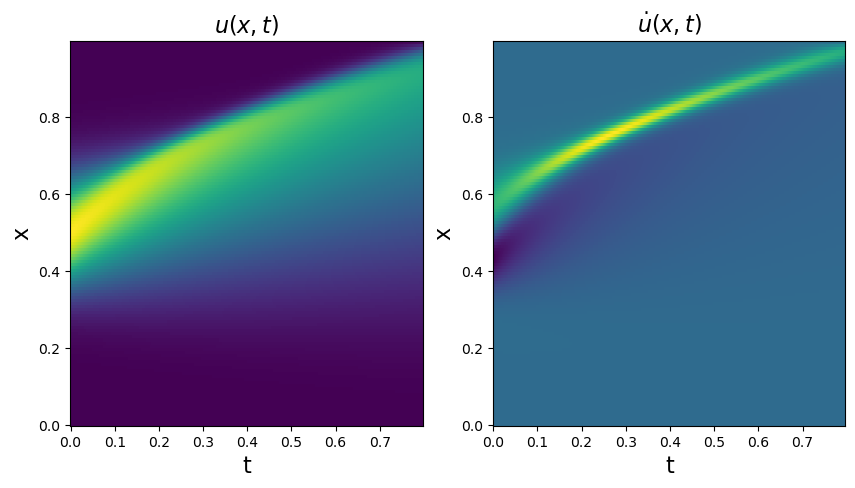

In [9]:
# PLOT FULL DATA
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t_sample, circ_sample, u_sample)
ax[1].pcolormesh(t_sample,circ_sample,u_dot_sample)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

## Model Selection

In [10]:
# define u_training
#training_time = np.concatenate((time_train, time_val))
t_training = t_sample[time_train]
#u_training = np.vstack((u_train_T, u_val_T)).T
u_training = u_train_T.T

# define u_training_dot
u_dot_training_true = u_dot_sample[:, time_train]

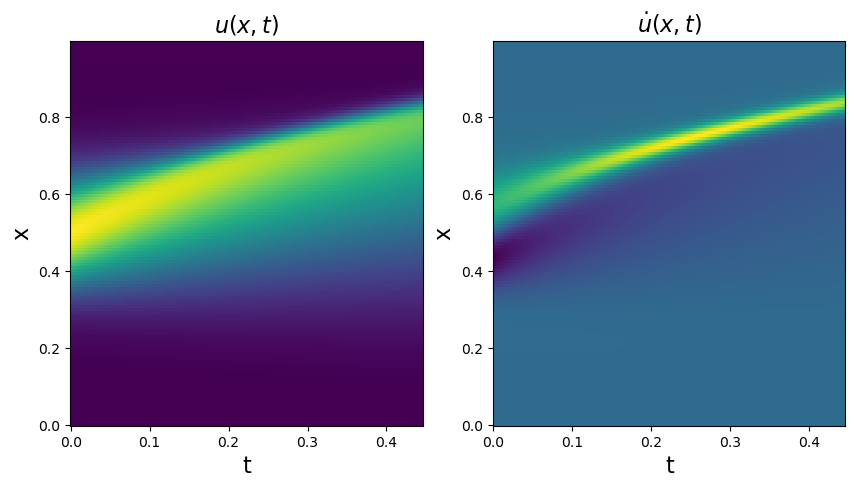

In [11]:
# PRINT TRAINING DATA
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t_training, circ_sample, u_training)
ax[1].pcolormesh(t_training,circ_sample,u_dot_training_true)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

In [12]:
# reshape u_training and u_dot_training
u_training_reshape = u_training.reshape(len(circ_sample), len(time_train), 1)
u_training_dot_reshape = u_dot_training_true.reshape(u_dot_training_true.shape[0], 
                                                     u_dot_training_true.shape[1], 1)

In [13]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=5,
    spatial_grid=circ_sample,
    is_uniform=True,
)

optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True, verbose=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)

In [14]:
u_val = u_val_T.T
u_val_reshape = u_val.reshape(u_val.shape[0], u_val.shape[1], 1)

u_dot_val_true = u_dot_sample[:, time_val]

In [15]:
# grid search params
threshold_list = [1, 2.5, 5, 7.5, 10]
alpha_list = [1e-1, 1e-2,1e-3, 1e-4, 1e-5]

In [16]:
#GRID SEARCH
def grid_search(threshold_list, alpha_list):
    curr_best_error = 1000
    for threshold in threshold_list:
        for alpha in alpha_list:
            optimizer = ps.STLSQ(threshold=threshold, alpha=alpha, normalize_columns=True, verbose=False)
            model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
            model.fit(u_training_reshape, t=dt_norm*skip_dt)
            u_dot_val = model.predict(u_val_reshape)[:,:,0]
            val_err = np.mean(np.linalg.norm(u_dot_val_true - u_dot_val, axis=0)**2)
            if val_err <= curr_best_error:
                curr_best_error = val_err
                best_params = (threshold, alpha)
    return curr_best_error, best_params

In [17]:
curr_best_error, best_params = grid_search(threshold_list, alpha_list)
print(curr_best_error)
print(best_params)

0.0005499227854177786
(10, 0.1)


In [18]:
# fit without u_t
#print('STLSQ model:')
#model.fit(u_training_reshape, t=dt_norm*skip_dt)
#model.print()

In [19]:
# compute validation error


#u_dot_val = model.predict(u_val_reshape)[:,:,0]
#print(np.mean(np.linalg.norm(u_dot_val_true - u_dot_val, axis=0)**2))

## Model assessment

In [20]:
# define u_train_val
time_train_val = np.concatenate((time_train, time_val))
t_train_val = t_sample[time_train_val]
u_train_val = np.vstack((u_train_T, u_val_T)).T

# define u_training_dot
u_dot_train_val_true = u_dot_sample[:, time_train_val]

In [21]:
# reshape u_train_val and u_dot_train_val
u_train_val_reshape = u_train_val.reshape(len(circ_sample), len(time_train_val), 1)
u_train_val_dot_reshape = u_dot_train_val_true.reshape(u_dot_train_val_true.shape[0], 
                                                     u_dot_train_val_true.shape[1], 1)
print(u_train_val_reshape.shape)


(128, 819, 1)


In [22]:
# fit without u_t
optimizer = ps.STLSQ(threshold=best_params[0], alpha=best_params[1], normalize_columns=True, verbose=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
print('STLSQ model:')
model.fit(u_train_val_reshape, t=dt_norm*skip_dt)
model.print()

STLSQ model:
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.3423e+03 ... 8.2761e+03 ...         11 ... 9.6184e+03
         1 ... 1.1566e+03 ... 8.2972e+03 ...         11 ... 9.4538e+03
(x0)' = -0.012 x0x0 + -0.001 x0_1 + 0.005 x0_11 + -0.992 x0x0_1 + -0.006 x0x0x0_1


In [23]:
# compute new training error
u_dot_train_val = model.predict(u_train_val_reshape)[:,:,0]
print(np.mean(np.linalg.norm(u_dot_train_val_true - u_dot_train_val, axis=0)**2))

0.0013889916755369935


In [24]:
# defining u_test
u_test = u_test_T.T
u_test_reshape = u_test.reshape(u_test.shape[0], u_test.shape[1], 1)

In [25]:
# define u_dot_test_true and compute u_test
t_test = t[time_test]
u_dot_test_true = u_dot_sample[:, time_test]
u_dot_test = model.predict(u_test_reshape)[:,:,0]

In [26]:
# compute test error
print(np.mean(np.linalg.norm(u_dot_test_true - u_dot_test, axis=0)**2))

0.05686988392734787


## True $\dot{u}$ vs computed $\dot{u}$

In [27]:
# reconstruct u_dot_true_model
u_dot_model = np.zeros_like(u_sample)
u_dot_model[:, time_train_val] = u_dot_train_val
u_dot_model[:, time_test] = u_dot_test

In [28]:
# compute total error
print(np.mean(np.linalg.norm(u_dot_model - u_dot_sample, axis=0)**2))

0.0124960062376671


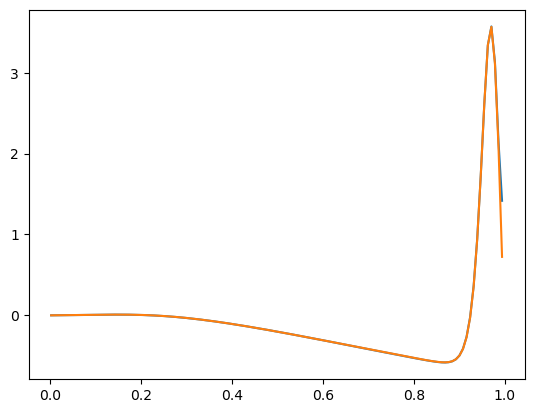

In [29]:
# COMPARISON udot_true VS udot_predict 
# check u_dot profile in the last test time
single_test_time = time_test[-1]
plt.plot(circ_sample, u_dot_model[:,single_test_time])
plt.plot(circ_sample, u_dot_sample[:, single_test_time])
plt.show()

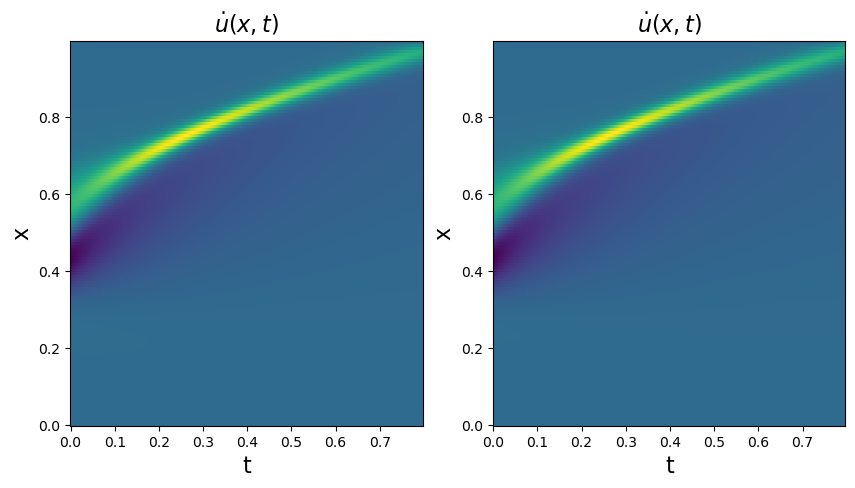

In [30]:
# COMPARISON udot_true VS udot_predict 
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t_sample,circ_sample,u_dot_sample)
ax[1].pcolormesh(t_sample, circ_sample, u_dot_model)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$\dot{u}(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()